# Gradient Booster Model
### Made by Julia Drygalska (model, fine-tuning) and Mikolaj Jodlowski (research about which model to choose, comparision and data preparation)

### First we have to import all the libraries we need

In [17]:
# Train Linear Regression model with validation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
import lightgbm as lgb
import matplotlib as mpl

### Then proceed to loading the dataset for trainig, drop the unnecessary null values, convert the categorical columns or drop them if they are not necessary and split the data into training and validation sets 

In [18]:

# Load and prepare data
print("Loading dataset...")
data = pd.read_csv('./datasets/train_data.csv')

# Drop rows with missing target values
data.dropna(subset=['price'], inplace=True)

# Convert categorical columns using OrdinalEncoder
categorical_columns = ['property_type', 'old/new', 'duration', 'town/city', 'district', 'county', 'ppdcategory_type']
encoder = OrdinalEncoder()
data[categorical_columns] = encoder.fit_transform(data[categorical_columns])

# Convert date_of_transfer to datetime and extract year, month, and day
print("Converting 'date_of_transfer' to datetime and extracting features...")
data['date_of_transfer'] = pd.to_datetime(data['date_of_transfer'])
data['year'] = data['date_of_transfer'].dt.year
data['month'] = data['date_of_transfer'].dt.month
data['day'] = data['date_of_transfer'].dt.day

# Drop unnecessary columns
X = data.drop(columns=['price', 'transaction_unique_identifier', 'record_status_-_monthly_file_only', 'date_of_transfer'])
y = data['price']

# Split data into training and validation sets
print("Splitting the data into training and validation sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


Loading dataset...
Converting 'date_of_transfer' to datetime and extracting features...
Splitting the data into training and validation sets...


### After we do this, we can stat creating our model

### This section of the code focuses on fine-tuning a LightGBM Regressor using GridSearchCV to find the best hyperparameters for improved model performance. The ultimate goal here is to enhance the model's predictive power by optimizing the key parameters that control its learning process.

### The next steps are:
### Initialize base model
### Set up GridSearchCV to find the best combination of parameters
### Train the model with GridSearchCV
### Update model with Best Parameters
### Make Predictions
### Evaluate model

In [19]:
# Fine-tune LightGBM model with reduced search space
print("Fine-tuning LightGBM model with GridSearchCV...")
grid_params = {
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10, -1],
    'num_leaves': [15, 31, 63],
    'n_estimators': [50, 100]
}

gb_model = lgb.LGBMRegressor(objective='regression', metric='rmse')
grid_search = GridSearchCV(gb_model, grid_params, cv=3, n_jobs=-1, verbose=1)
print("Training GridSearchCV...")
grid_search.fit(X_train_final, y_train_final)

# Update model with best parameters
print("Best Parameters found:")
print(grid_search.best_params_)
model = lgb.LGBMRegressor(**grid_search.best_params_)
model.fit(X_train_final, y_train_final)

# Make predictions on the validation data
print("Making predictions on the validation data...")
y_val_pred = model.predict(X_val)

# Evaluate the model on validation data
print("Evaluating the model...")
val_mse = mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)
print(f"Validation - Mean Squared Error: {val_mse}")
print(f"Validation - R^2 Score: {val_r2}")

Fine-tuning LightGBM model with GridSearchCV...
Training GridSearchCV...
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 3417055, number of used features: 10
[LightGBM] [Info] Start training from score 239888.527538
Best Parameters found:
{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 100, 'num_leaves': 63}
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092327 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 675
[LightGBM] [Info] Number of data points in the train set: 3417055, number of used features: 

### This process takes a lot of time so do not worry, in my case it takes around 14 minutes I managed to get the r2 score of     0.59, so not that high but also not abysmal (like it used to be for many hours)

### After that we can train our final model with the parameters used by the fine-tuning above

In [20]:
# Train final model on entire training set
print("\nTraining final model on the entire training set...")
final_model = lgb.LGBMRegressor(**grid_search.best_params_)
final_model.fit(X_train, y_train)



Training final model on the entire training set...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.093481 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 676
[LightGBM] [Info] Number of data points in the train set: 4271319, number of used features: 10
[LightGBM] [Info] Start training from score 239910.616717


LGBMRegressor(num_leaves=63)

### It's time to test our final model with the actual test dataset. After we load the test dataset, transform categorical columns into numerical values that can be used by the model, extract additional temporal features from the date_of_transfer column and prepare features and target for the evaluation



In [21]:


# Load test data
print("Loading test dataset...")
test_data = pd.read_csv('./datasets/test_data.csv')

# Convert categorical columns using OrdinalEncoder in test data
test_data[categorical_columns] = encoder.transform(test_data[categorical_columns])

# Convert date_of_transfer to datetime and extract year, month, and day in test data
print("Converting 'date_of_transfer' to datetime and extracting features in test data...")
test_data['date_of_transfer'] = pd.to_datetime(test_data['date_of_transfer'])
test_data['year'] = test_data['date_of_transfer'].dt.year
test_data['month'] = test_data['date_of_transfer'].dt.month
test_data['day'] = test_data['date_of_transfer'].dt.day

# Drop unnecessary columns in test data
X_test = test_data.drop(columns=['price', 'transaction_unique_identifier', 'record_status_-_monthly_file_only', 'date_of_transfer'])
y_test = test_data['price']

# Make predictions on the test data
print("Making predictions on the test data...")
y_pred = final_model.predict(X_test)

# Evaluate the final model
print("Evaluating the final model...")
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)
print(f"Final Model - Mean Squared Error: {final_mse}")
print(f"Final Model - R^2 Score: {final_r2}")


Loading test dataset...
Converting 'date_of_transfer' to datetime and extracting features in test data...
Making predictions on the test data...
Evaluating the final model...
Final Model - Mean Squared Error: 23889596464.447803
Final Model - R^2 Score: 0.5357303620661515


### Next, we can save the path and the file 

In [22]:

# Save predictions for future reference
predictions_path = './datasets/predictions_gradient_boosting.csv'
print("Saving predictions...")
predictions = pd.DataFrame({'date_of_transfer': test_data['date_of_transfer'], 'Actual': y_test, 'Predicted': y_pred})

predictions.to_csv(predictions_path, index=False)


Saving predictions...


### Finally, compare the models predictions with the actual data from the test.csv file which contains the actual prices for UK housing.

Visualizing the predictions...


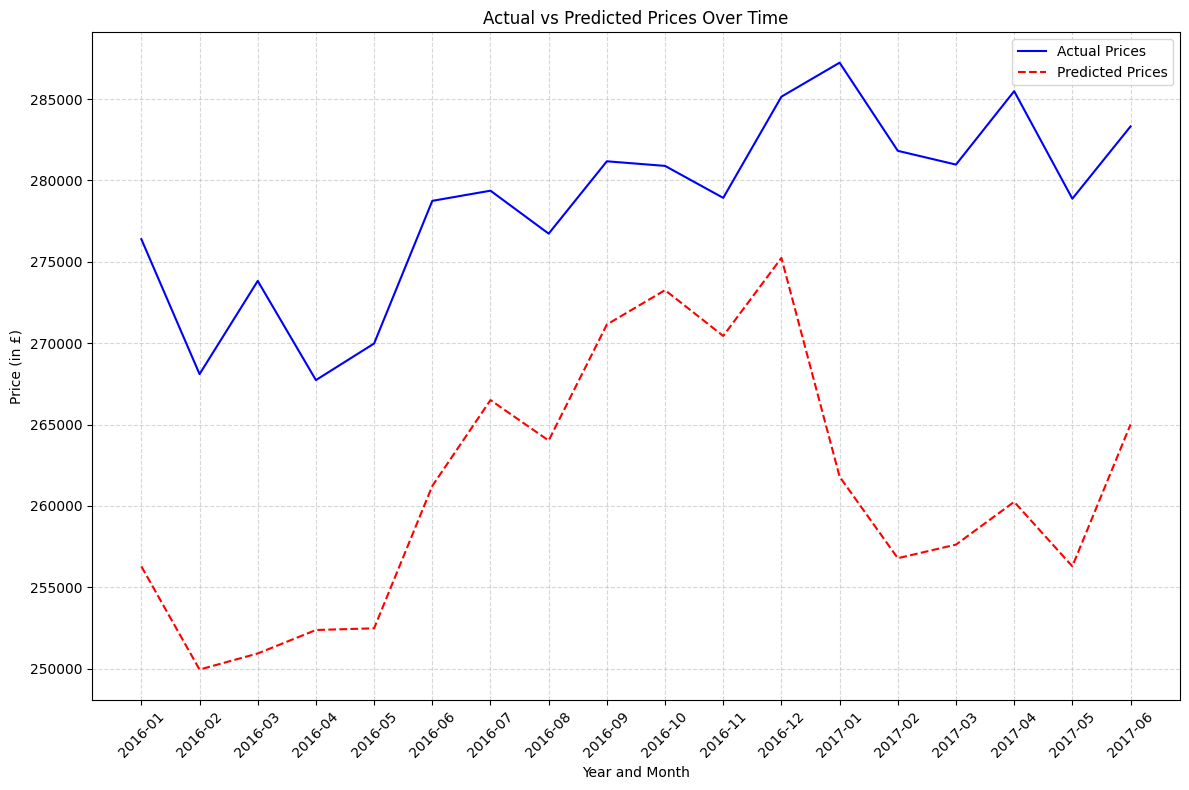

In [23]:
# Adjust rcParams to avoid OverflowError
mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams['path.simplify_threshold'] = 1.0

print("Visualizing the predictions...")
plt.figure(figsize=(12, 8))

# Convert date_of_transfer to 'Year-Month' format for grouping and plotting
predictions['year_month'] = predictions['date_of_transfer'].dt.to_period('M')

# Group data by 'year_month' to take the mean for smoother lines
predictions_grouped = predictions.groupby('year_month').mean().reset_index()


# Plot the actual and predicted prices over time
plt.plot(predictions_grouped['year_month'].astype(str), predictions_grouped['Actual'], label='Actual Prices', color='blue')
plt.plot(predictions_grouped['year_month'].astype(str), predictions_grouped['Predicted'], label='Predicted Prices', color='red', linestyle='--')

plt.xlabel('Year and Month')
plt.ylabel('Price (in £)')
plt.title('Actual vs Predicted Prices Over Time')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(visible=True, linestyle='--', alpha=0.5)
plt.show()